In [230]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [249]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

tt = f"""
  SELECT 
    partition_date,
    IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
    session_key,
    sessionId,
    IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
    IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
    IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
    IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) orderId,
    IFNULL(shopListType, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopListType'))) shopListType,
    IFNULL(shopId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopId'))) shopId,
    IFNULL(shopPosition, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopPosition'))) shopPosition,
    IFNULL(eventOrigin, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('origin'))) eventOrigin,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuality')), '') shopRatingQuality,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('businessType')), '') businessType,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuantity')), '') shopRatingQuantity,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopMinimumOrderValue')), '') shopMinimumOrderValue,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')), '') vendor_delivery_fee,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryTime')), '') shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction IN ('shop_impressions.loaded')
    AND session_key = '2hfGxiUpOdChbyOhA1YRIQ=='
"""

test = client.query(tt).to_dataframe()


/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



In [250]:
test

,partition_date,global_entity_id,session_key,sessionId,platform,perseus_session_id,perseus_hit_match_id,orderId,shopListType,shopId,shopPosition,eventOrigin,shopRatingQuality,businessType,shopRatingQuantity,shopMinimumOrderValue,vendor_delivery_fee,shopDeliveryTime
0,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770972.000000001375247997.0001uxcy3m,1189995736,RESTAURANT,461856,None,None,4.59,"RESTAURANT,PHARMACY",78,0.0,0.0,15-30 min
1,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770965.000000001227393229.0000sbnoof,1189995736,PHARMACY,282712,None,None,4.6,"RESTAURANT,PHARMACY",52,0.0,0.0,15-30 min
2,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770996.000000004124261785.0000sc5woh,1189995736,RESTAURANT,306166,None,None,4.39,"RESTAURANT,PHARMACY",64,0.0,0.0,15-30 min
3,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770958.000000000093700276.0001qy0s24,1189995736,RESTAURANT,270798,None,None,4.47,"RESTAURANT,PHARMACY",333,0.0,0.0,15-30 min
4,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770981.000000003496616722.000127i8iq,1189995736,RESTAURANT,446934,None,None,4.47,"RESTAURANT,PHARMACY",45,0.0,0.0,25-40 min
5,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770933.000000002587940286.00000fd2kc,1189995736,RESTAURANT,409399,None,None,4.49,"RESTAURANT,PHARMACY",122,0.0,0.0,15-30 min
6,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770949.000000000404319655.0001mzecem,1189995736,RESTAURANT,440322,None,None,4.7,"RESTAURANT,PHARMACY",71,0.0,0.0,20-35 min
7,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770989.000000001556814922.0001m79myt,1189995736,RESTAURANT,363250,None,None,4.57,"RESTAURANT,PHARMACY",74,0.0,0.0,5-20 min
8,2024-06-01,PY_EC,2hfGxiUpOdChbyOhA1YRIQ==,1717030504197.000000001074390042.000052zlcp,Web,1717030504197.000000001074390042.000052zlcp,1717274770941.000000003801273387.00002a2j5y,1189995736,RESTAURANT,278632,None,None,4.63,"RESTAURANT,PHARMACY",51,0.0,0.0,10-25 min


In [255]:
tt_t = f"""
select o.country_code, 
  o.zone_name,
  o.platform_order_code, 
  o.dps_session_id,
  o.order_id
from fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders o
left join fulfillment-dwh-production.cl.countries c ON o.country_code = c.country_code
where o.dps_session_id = '1717030504197.000000001074390042.000052zlcp'
      and o.entity_id = 'PY_EC'
"""

test_tt = client.query(tt_t).to_dataframe()


/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



In [256]:
test_tt

,country_code,zone_name,platform_order_code,dps_session_id,order_id
0,ec,Loja,1190022159,1717030504197.000000001074390042.000052zlcp,24989621
1,ec,Loja,1188684465,1717030504197.000000001074390042.000052zlcp,24934209


In [247]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

orders = f"""
    SELECT
        country_name,
        country_code,
        entity_id,
        created_date,
        order_id
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    where order_id = 1189995736
    """

orders_data_match = client.query(orders).to_dataframe()
orders_data_match

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,country_name,country_code,entity_id,created_date,order_id


In [234]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

query = f"""
with impression_data as (
  SELECT 
    partition_date,
    IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
    IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
    IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
    IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
    IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) orderId,
    IFNULL(shopListType, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopListType'))) shopListType,
    IFNULL(shopId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopId'))) shopId,
    IFNULL(shopPosition, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopPosition'))) shopPosition,
    IFNULL(eventOrigin, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('origin'))) eventOrigin,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuality')), '') shopRatingQuality,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('businessType')), '') businessType,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuantity')), '') shopRatingQuantity,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopMinimumOrderValue')), '') shopMinimumOrderValue,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')), '') vendor_delivery_fee,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryTime')), '') shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction = 'shop_impressions.loaded'
),
aggregation as (
SELECT 
  global_entity_id,
  count(distinct perseus_session_id) as total_sessions,
  count(distinct perseus_hit_match_id) as total_hits,
  count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuality,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quality_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuantity,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quantity_hits,
  count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits,
  count(distinct case when cast(regexp_extract(shopDeliveryTime,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as delivery_time_hits,
  count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
FROM impression_data
GROUP BY 1
)
select a.*,
       1.00 * (fee_hits / total_hits) fee_completeness,
       1.00 * (quality_hits / total_hits) quality_completeness,
       1.00 * (quantity_hits / total_hits ) quantity_completeness,
       1.00 * (mov_hits / total_hits ) mov_completeness,
       1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness,
       1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
from aggregation a
"""

impression_data_completeness = client.query(query).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 



KeyboardInterrupt: 

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_51740/960183126.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



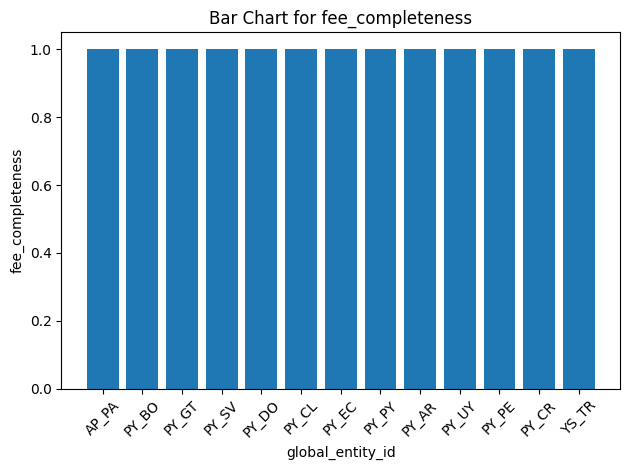

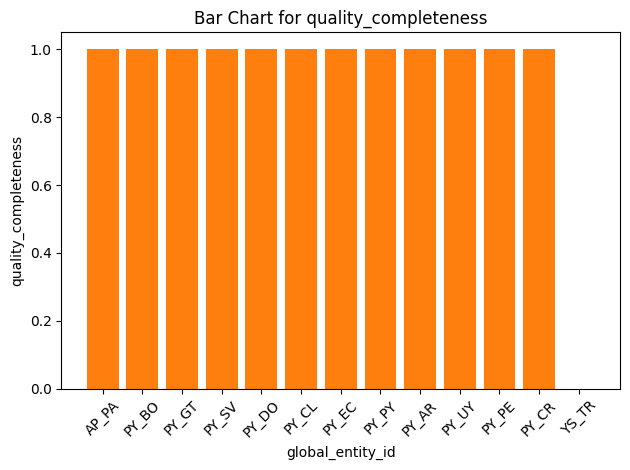

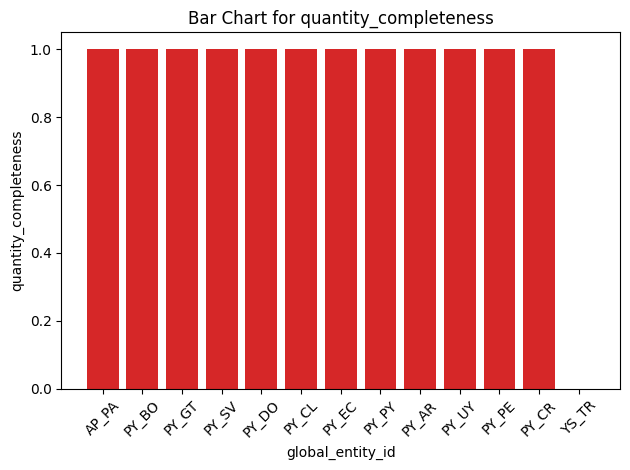

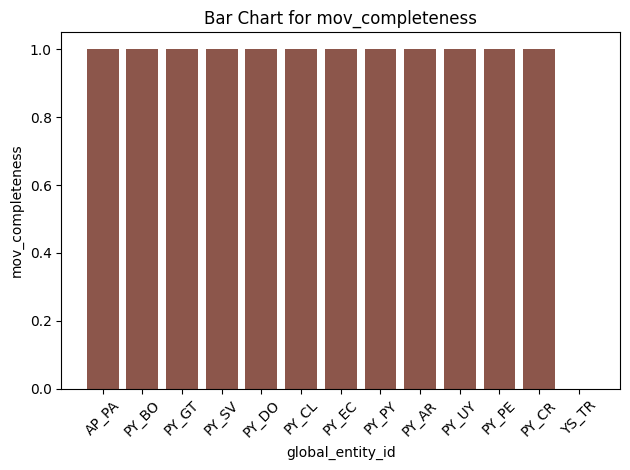

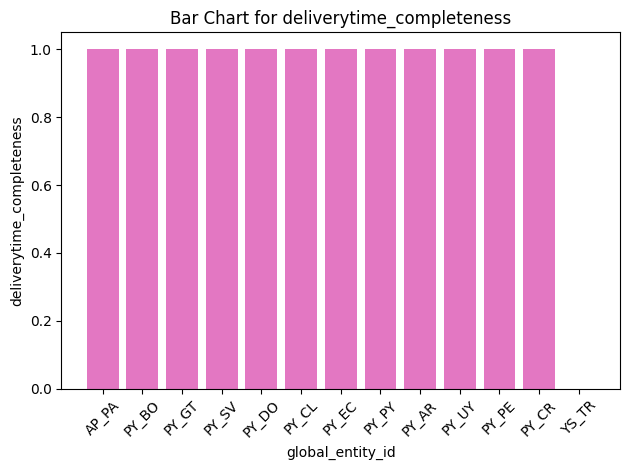

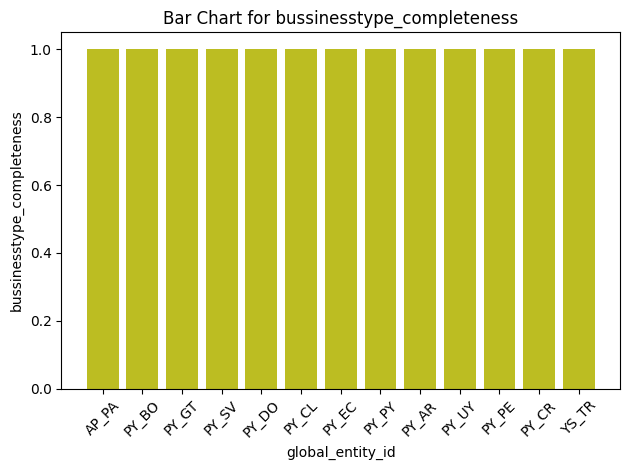

In [ ]:
# Assuming 'test' is your DataFrame and 'cols' is your list of columns
cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

# Assuming 'global_entity_id' is the x-axis column
x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = impression_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  # Choose a colormap (e.g., 'tab10' for 10 distinct colors)

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    
    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  # Use colormap to get a color
    ax.bar(x_data, impression_data_completeness[col], color=color)
    
    # Set labels and title
    ax.set_xlabel(x_axis_column)
    ax.set_ylabel(col)
    ax.set_title(f'Percentage of hits with {col}')
    
    # Optionally, rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()  # Adjust layout for better presentation
    plt.show()

In [ ]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-07'

query = f"""
with impression_data as (
  SELECT 
    partition_date,
    IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
    IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
    IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
    IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
    IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) orderId,
    IFNULL(shopListType, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopListType'))) shopListType,
    IFNULL(shopId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopId'))) shopId,
    IFNULL(shopPosition, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopPosition'))) shopPosition,
    IFNULL(eventOrigin, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('origin'))) eventOrigin,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuality')), '') shopRatingQuality,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('businessType')), '') businessType,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuantity')), '') shopRatingQuantity,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopMinimumOrderValue')), '') shopMinimumOrderValue,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')), '') vendor_delivery_fee,
    IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryTime')), '') shopDeliveryTime
  FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND eventAction = 'shop_impressions.loaded'
),
aggregation as (
SELECT 
  global_entity_id,
  SUBSTR(global_entity_id, 1, STRPOS(global_entity_id, '_') - 1) entity_grouping,
  partition_date,
  count(distinct perseus_session_id) as total_sessions,
  count(distinct perseus_hit_match_id) as total_hits,
  count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuality,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quality_hits,
  count(distinct case when cast(regexp_extract(shopRatingQuantity,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quantity_hits,
  count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits,
  count(distinct case when cast(regexp_extract(shopDeliveryTime,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as delivery_time_hits,
  count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
FROM impression_data
GROUP BY 1,2,3
)
select a.*,
       1.00 * (fee_hits / total_hits) fee_completeness,
       1.00 * (quality_hits / total_hits) quality_completeness,
       1.00 * (quantity_hits / total_hits ) quantity_completeness,
       1.00 * (mov_hits / total_hits ) mov_completeness,
       1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness,
       1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
from aggregation a
"""

impression_data_time = client.query(query).to_dataframe()

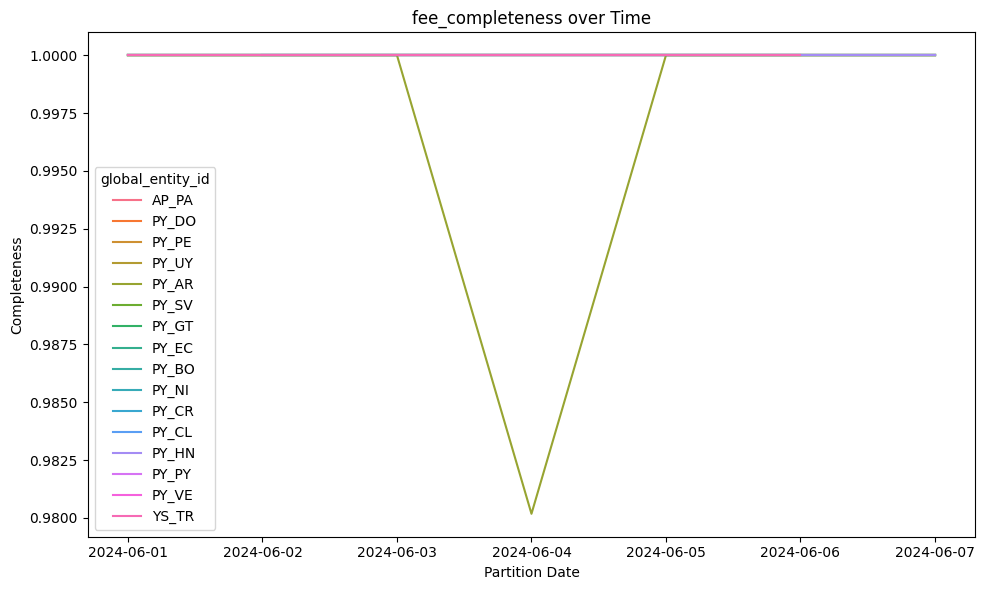

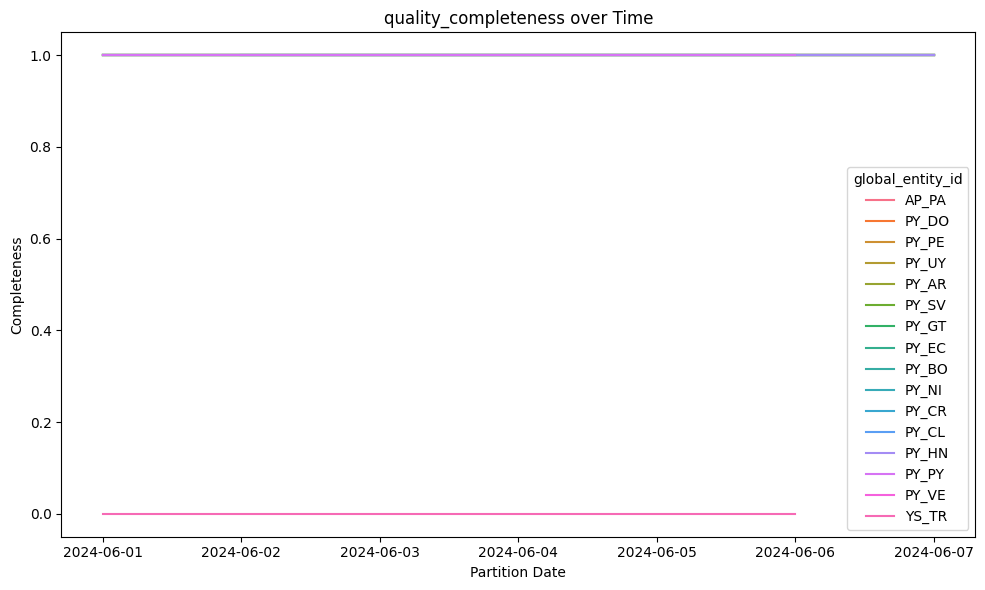

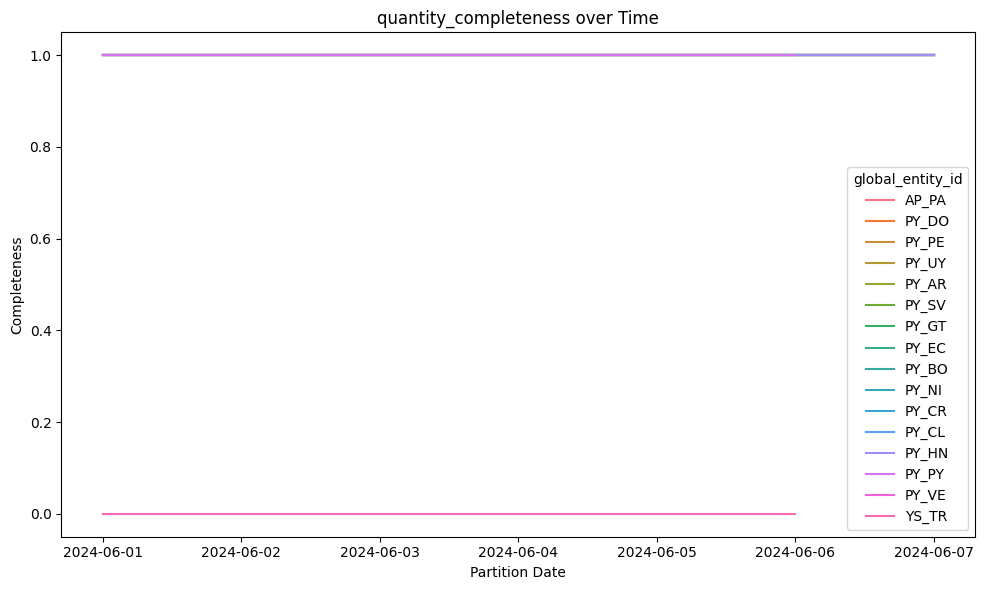

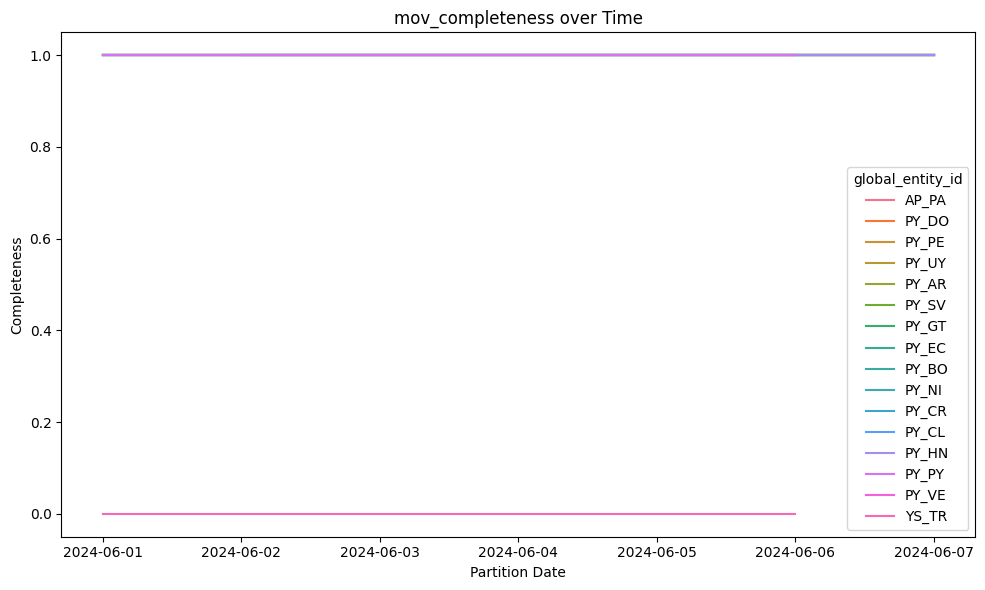

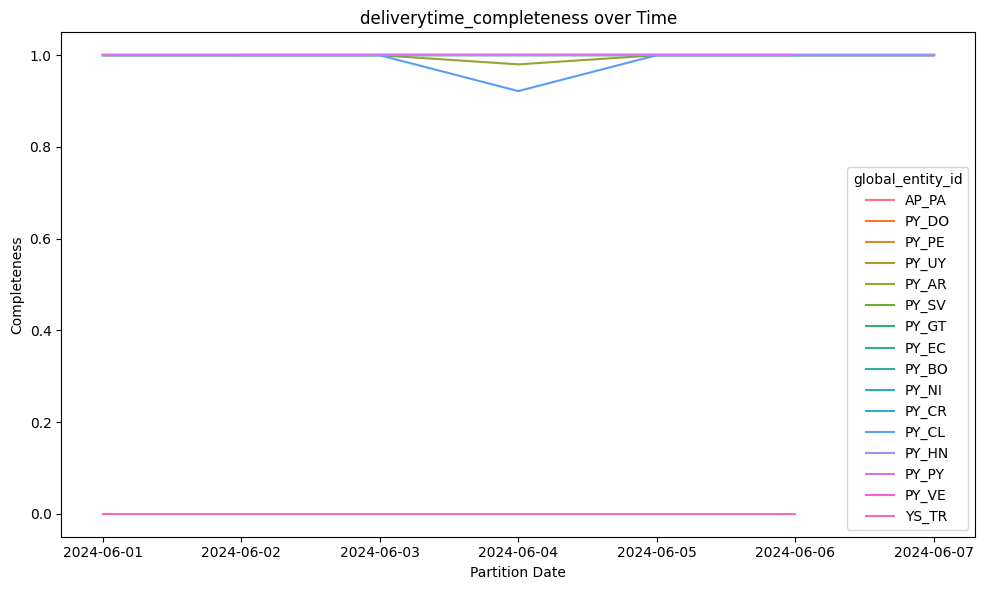

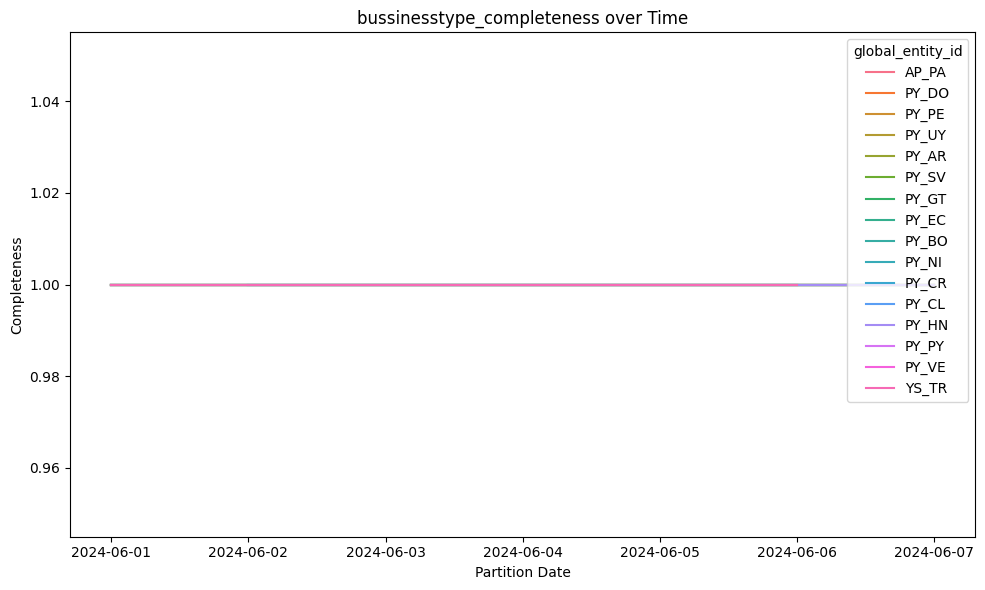

In [ ]:
cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

# Iterate through each column and create a separate figure for each
for col in cols:
    # Create a new figure for each column
    plt.figure(figsize=(10, 6))
    # Plot the data for the current column
    sns.lineplot(data=impression_data_time, x='partition_date', y=col, hue='global_entity_id')
    plt.title(f'{col} over Time')  # Set title for the current figure
    plt.xlabel('Partition Date')  # Label for x-axis
    plt.ylabel('Completeness')  # Label for y-axis
    plt.tight_layout()  # Ensures labels are not cut off
    plt.show()

In [225]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

orders = f"""
    with impression_data as (
    SELECT 
        country,
        IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
        partition_date,
        IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) order_id 
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
    WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        AND eventAction = 'shop_impressions.loaded'
        AND IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) is not null
    ), 
    order_data as (
    SELECT
        country_name,
        country_code,
        entity_id,
        created_date,
        order_id
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    where created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
          AND order_id is not null
    )
    select  coalesce(od.entity_id, id.global_entity_id) entity_id,
            count (distinct od.order_id) total_orders_sessions_m,
            count (distinct id.order_id) total_orders_impressions_data
    from impression_data id
    left join order_data od on cast(id.global_entity_id as string) = cast(od.entity_id as string) and cast(id.order_id as string) = cast(od.order_id as string)
    group by 1
    """

orders_data_match = client.query(orders).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 



KeyboardInterrupt: 

In [ ]:
orders_data_match

,entity_id,total_orders_sessions_m,total_orders_impressions_data
0,None,0,0
1,PY_AR,0,27
2,TB_JO,0,1
3,FP_SG,0,0
4,PY_PE,0,2
5,FP_MY,0,0
6,FP_KH,0,0
7,FP_PH,0,0
8,TB_IQ,0,1
9,TB_AE,0,1


In [207]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

orders = f"""
    SELECT
        country_name,
        country_code,
        entity_id,
        created_date,
        order_id
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    where created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        AND order_id is not null
    limit 5
    """

orders_data_match = client.query(orders).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



In [220]:
orders_data_match

,entity_id,total_orders_sessions_m,total_orders_impressions_data
0,ODR_MM,271,0
1,PY_AR,356487,0
2,ODR_DK,4,0
3,TB_JO,67545,0
4,FP_SG,77702,0
...,...,...,...
56,FP_MM,34061,0
57,DJ_CZ,32792,0
58,HS_SA,513268,0
59,FP_LA,7878,0


In [229]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'

orders = f"""
    SELECT 
        country,
        IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
        partition_date,
        IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) order_id 
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
    WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        AND eventAction = 'shop_impressions.loaded'
        AND ( IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) is not null OR 
            IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) <> 'NA' )
    group by 1,2
    """

orders_data_match = client.query(orders).to_dataframe()
orders_data_match

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,country,global_entity_id,partition_date,order_id
0,PE,PY_PE,2024-06-01,1189666700
1,PE,PY_PE,2024-06-01,1189666700
2,PE,PY_PE,2024-06-01,1189666700
3,PE,PY_PE,2024-06-01,1189666700
4,PE,PY_PE,2024-06-01,1189666700
...,...,...,...,...
88997,KW,TB_KW,2024-06-01,NA
88998,KW,TB_KW,2024-06-01,NA
88999,KW,TB_KW,2024-06-01,NA
89000,KW,TB_KW,2024-06-01,NA


In [227]:
orders_data_match

,country,global_entity_id,partition_date,order_id
0,PE,PY_PE,2024-06-01,1189666700
1,PE,PY_PE,2024-06-01,1189666700
2,PE,PY_PE,2024-06-01,1189666700
3,PE,PY_PE,2024-06-01,1189666700
4,PE,PY_PE,2024-06-01,1189666700
...,...,...,...,...
88997,AE,TB_AE,2024-06-01,NA
88998,AE,TB_AE,2024-06-01,NA
88999,AE,TB_AE,2024-06-01,NA
89000,AE,TB_AE,2024-06-01,NA


In [19]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# WITH
# impression_data AS (
#   SELECT DISTINCT
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')) vendor_delivery_fee,
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# )
# SELECT
#   global_entity_id,
#   platform,
#   partition_date,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) fee_hits,
#   count(distinct perseus_hit_match_id) total_hits,
# FROM impression_data
# group by 1,2,3
# order by 1,2,3
# """

# test = client.query(query).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [20]:
# test['percentage'] = round(100 * (test['fee_hits'] / test['total_hits']),0)
# test.sort_values(by = 'percentage')

,global_entity_id,platform,partition_date,fee_hits,total_hits,percentage
9,EF_GR,Web,2024-06-01,0,116166,0.0
78,PY_PA,Android,2024-06-01,0,7,0.0
10,EF_GR,iOS,2024-06-01,0,558124,0.0
8,EF_GR,Android,2024-06-01,0,724190,0.0
106,TB_QA,Android,2024-06-01,914027,1995948,46.0
...,...,...,...,...,...,...
39,HN_DK,Android,2024-06-01,30634,30634,100.0
36,FP_TW,iOS,2024-06-01,50322023,50451762,100.0
35,FP_TW,Android,2024-06-01,15176142,15176393,100.0
70,PY_GT,Web,2024-06-01,1432,1432,100.0


In [26]:
# query = f"""
# SELECT
#     o.country_name,
#     o.entity_id,
#     o.region,
#     count(distinct o.order_id)
# FROM
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# where created_date between \"""" + start_date + """\" and \"""" + end_date + """\"
# limit 1
# """

# test = client.query(query).to_dataframe()
# test

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country_name,entity_id,region,fe_session_id,dps_session_id,order_id
0,None,TB_KW,None,1717235109610.4600475705.mavxfyjdxk,1717235109610.4600475705.mavxfyjdxk,<NA>


In [ ]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# WITH
# impression_data AS (
#   SELECT DISTINCT
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')) vendor_delivery_fee,
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# )
# SELECT
#   global_entity_id,
#   platform,
#   partition_date,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) fee_hits,
#   count(distinct perseus_hit_match_id) total_hits,
# FROM impression_data
# group by 1,2,3
# order by 1,2,3
# """

# test = client.query(query).to_dataframe()

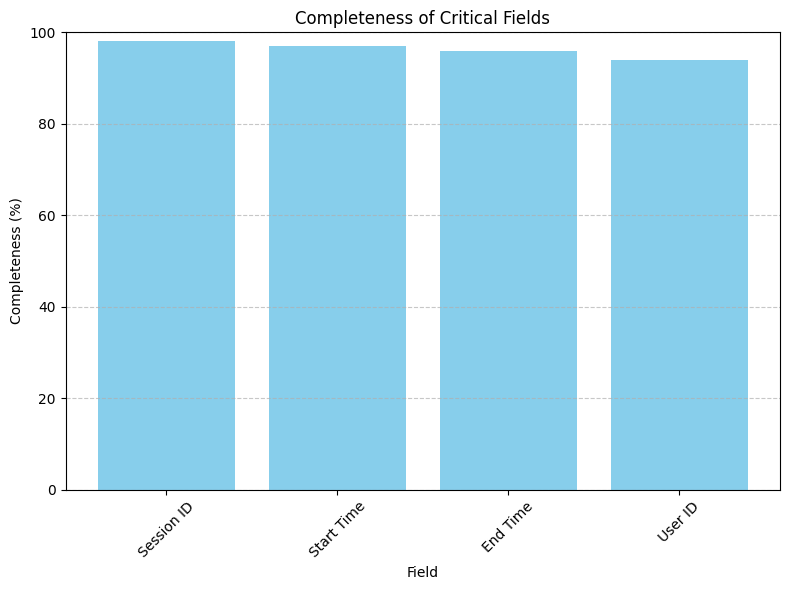

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
data = {
    'Field': ['Session ID', 'Start Time', 'End Time', 'User ID'],
    'Completeness (%)': [98, 97, 96, 94]  
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(df['Field'], df['Completeness (%)'], color='skyblue')
plt.title('Completeness of Critical Fields')
plt.xlabel('Field')
plt.ylabel('Completeness (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

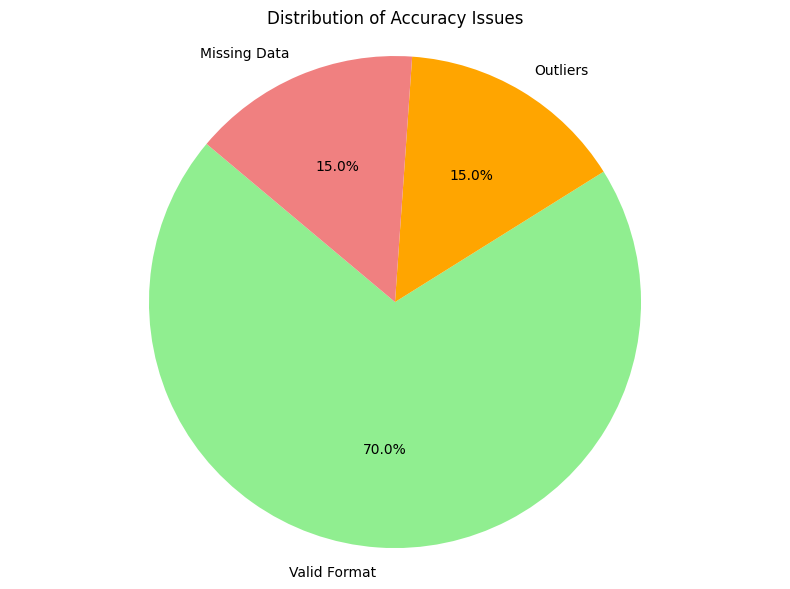

In [55]:
# Example data
labels = ['Valid Format', 'Outliers', 'Missing Data']
sizes = [70, 15, 15]  

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'orange', 'lightcoral'], startangle=140)
plt.title('Distribution of Accuracy Issues')
plt.axis('equal')
plt.tight_layout()
plt.show()

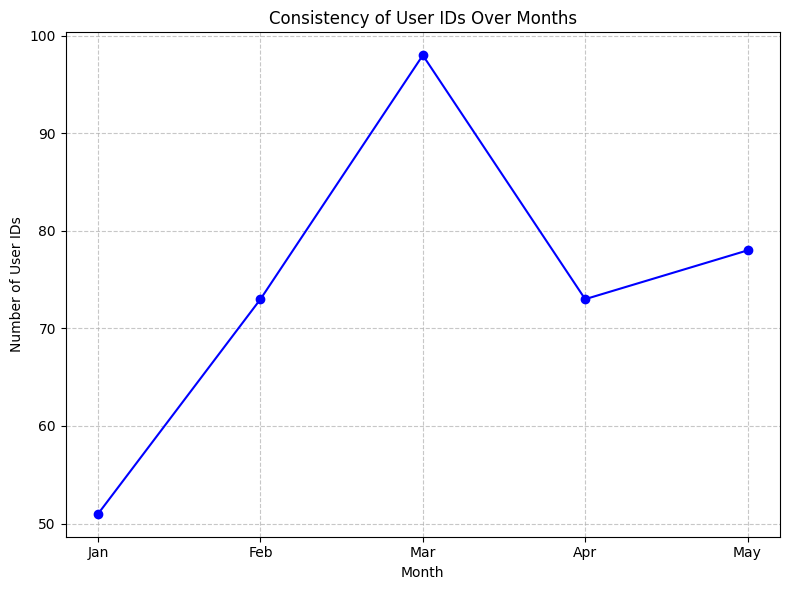

In [56]:
# Example data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
user_ids = np.random.randint(50, 100, size=len(months)) 

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(months, user_ids, marker='o', linestyle='-', color='b')
plt.title('Consistency of User IDs Over Months')
plt.xlabel('Month')
plt.ylabel('Number of User IDs')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

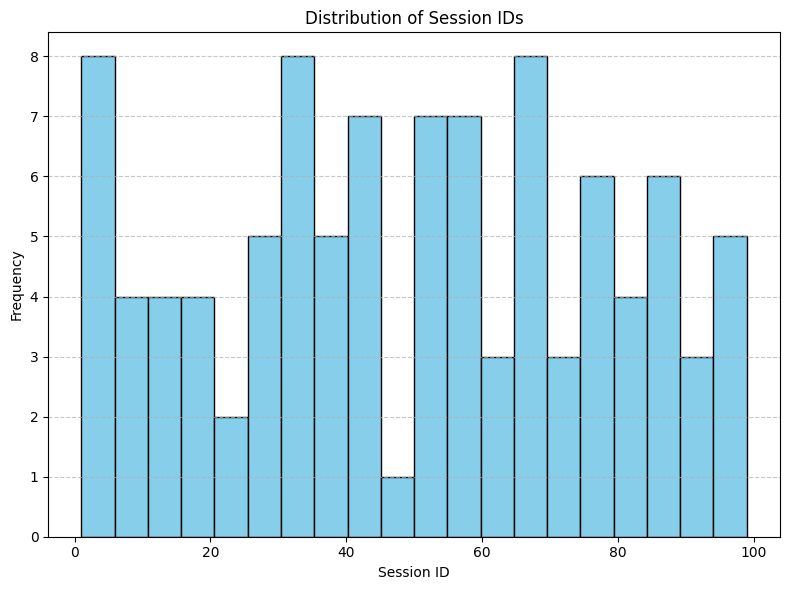

In [57]:
# Example data
session_ids = np.random.randint(1, 100, size=100) 

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(session_ids, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Session IDs')
plt.xlabel('Session ID')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

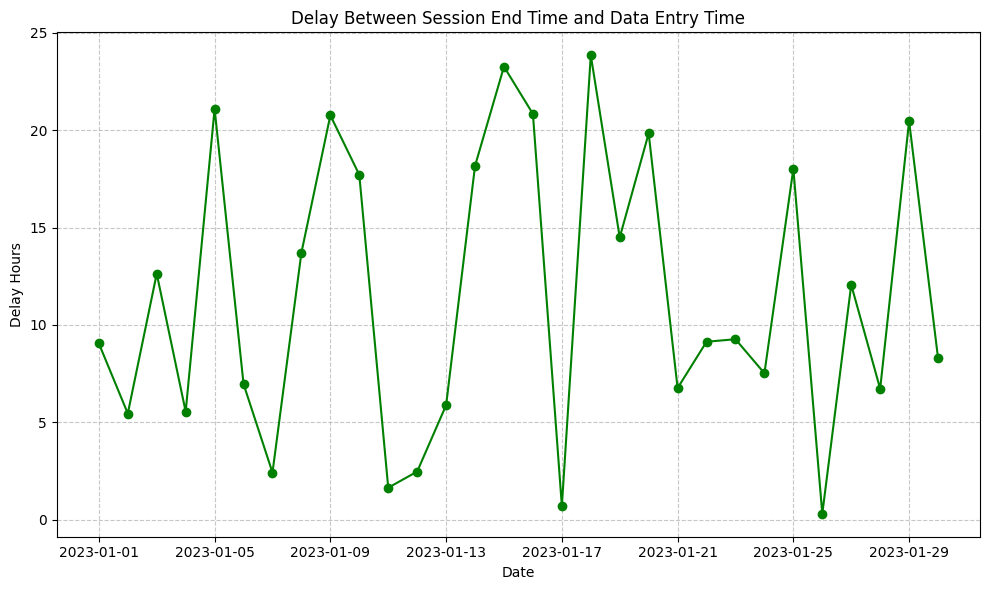

In [58]:
# Example data
dates = pd.date_range('2023-01-01', periods=30)
delay_hours = np.random.uniform(0, 24, size=30)  

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, delay_hours, marker='o', linestyle='-', color='g')
plt.title('Delay Between Session End Time and Data Entry Time')
plt.xlabel('Date')
plt.ylabel('Delay Hours')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [60]:
!pip3 install networkx

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


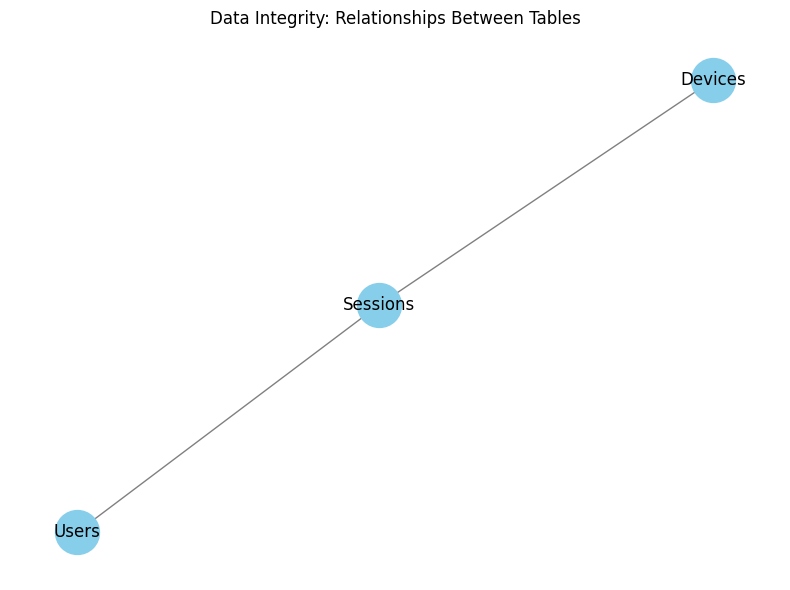

In [61]:
import networkx as nx

# Example data (simplified)
G = nx.Graph()
G.add_nodes_from(['Sessions', 'Users', 'Devices'])
G.add_edges_from([('Sessions', 'Users'), ('Sessions', 'Devices')])

# Plotting
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_family='sans-serif')
plt.title('Data Integrity: Relationships Between Tables')
plt.axis('off')
plt.tight_layout()
plt.show()

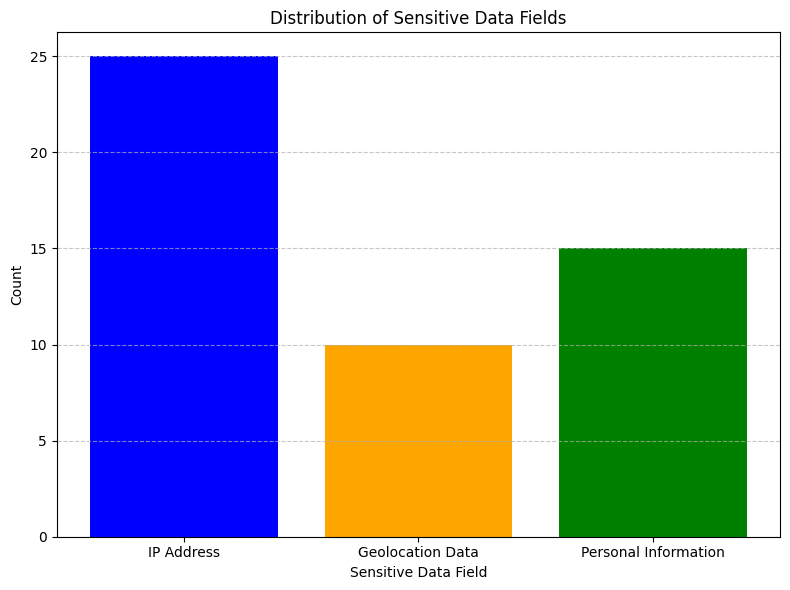

In [62]:
# Example data
fields = ['IP Address', 'Geolocation Data', 'Personal Information']
count = [25, 10, 15]  # Example count of sensitive fields

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(fields, count, color=['blue', 'orange', 'green'])
plt.title('Distribution of Sensitive Data Fields')
plt.xlabel('Sensitive Data Field')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

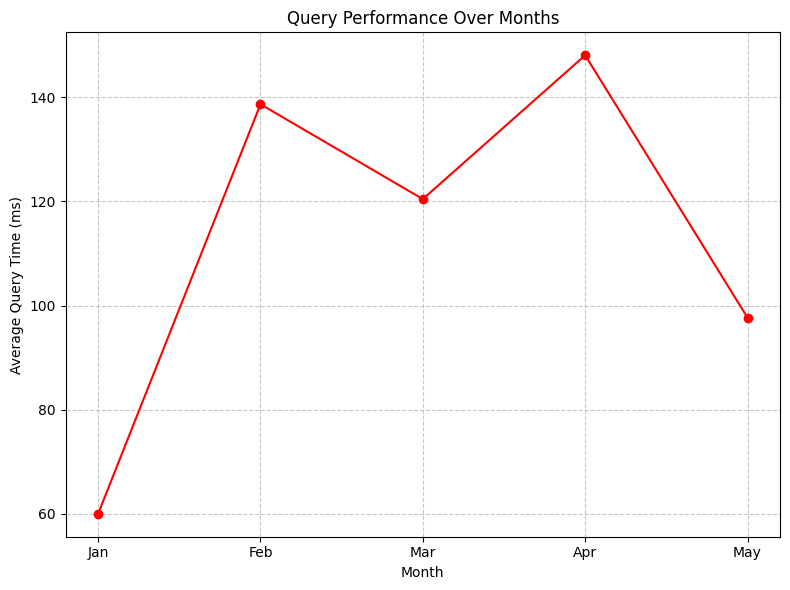

In [63]:
# Example data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
query_times = np.random.uniform(50, 150, size=len(months))  # Example random query times (ms)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(months, query_times, marker='o', linestyle='-', color='r')
plt.title('Query Performance Over Months')
plt.xlabel('Month')
plt.ylabel('Average Query Time (ms)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()